# Using Spatial Joins

In [1]:
import transportation_tutorials as tt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

## Questions

1. Within the SERPM 7 region, what TAZ has the largest number of MAZs within its 
   boundary?  How many does it have?
2. Generate a map of the MAZ boundaries within this TAZ, including context as necessary 
   from OpenStreetMaps.  What features of this TAZ helped lead to the large number of 
   MAZ's?

## Data

To answer the questions, use the following files:

In [2]:
maz = gpd.read_file(tt.data('SERPM8-MAZSHAPE'))
taz = gpd.read_file(tt.data('SERPM8-TAZSHAPE'))

In [3]:
maz.head()

,OBJECTID,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry
0,1,5347,8589.393674,3.111034e+06,71,953130,724165,"POLYGON ((953970.4660769962 723936.0810402408,..."
1,2,5348,11974.067469,7.628753e+06,175,907018,634551,"POLYGON ((908505.2801046632 635081.7738410756,..."
2,3,5349,9446.131753,4.007041e+06,92,923725,707062,"POLYGON ((922736.6374686621 708387.6918614879,..."
3,4,5350,21773.153739,2.487397e+07,571,908988,713484,"POLYGON ((908334.2374677472 715692.2628822401,..."
4,5,5351,17882.701416,1.963139e+07,451,909221,717493,"POLYGON ((911883.0187559947 719309.3261861578,..."


In [4]:
taz.head()

,OBJECTID,TAZ_REG,TAZ_OLD05,TAZ_MPO,COUNTY,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area,geometry
0,1,1122.0,1122,1122,1.0,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06,"POLYGON ((936374.6744969971 959539.5675094873,..."
1,2,17.0,17,17,1.0,None,0,0,15689400.0,0.8571,0,0,17396.297932,1.568938e+07,"POLYGON ((942254.5000076629 952920.9373740703,..."
2,3,1123.0,1123,1123,1.0,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((940953.5610084943 952985.0688074902,..."
3,4,1120.0,1120,1120,1.0,None,0,0,1303420.0,0.8536,0,0,7202.864864,1.303422e+06,"POLYGON ((953118.9999321625 951985.3749407381,..."
4,5,1121.0,1121,1121,1.0,None,0,0,31477500.0,0.8787,0,0,24940.959492,3.147748e+07,"POLYGON ((934328.2825924121 951600.5853559896,..."


## Solution

We use `.sjoin()` method in `geopandas` to perform spatial join between two different spatial resolutions. For this exercise, we need to join MAZs with TAZs and we do that based on TAZ polygons and MAZ centroids. For this purpose, we will create a new geo-dataframe for MAZs with centroids in the `geometry` column. 

In [5]:
maz_centroids = maz.copy()
maz_centroids.geometry = maz_centroids.apply(lambda x: Point(x.POINT_X, x.POINT_Y), axis = 1)

Now, we use `.sjoin()` method with `op = 'within'` to indicate that MAZ centroids must be located within TAZ polygons. 

In [6]:
taz_maz = gpd.sjoin(maz_centroids, taz, how = 'left', op = 'within')

In [7]:
taz_maz.head(2)

,OBJECTID_left,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry,index_right,OBJECTID_right,...,COUNTY,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area
0,1,5347,8589.393674,3.111034e+06,71,953130,724165,POINT (953130 724165),2068.0,2069.0,...,2.0,None,1811.0,0.0,6013680.0,0.7165,0.0,0.0,10593.246250,6.003915e+06
1,2,5348,11974.067469,7.628753e+06,175,907018,634551,POINT (907018 634551),1810.0,1811.0,...,2.0,None,2367.0,0.0,12256200.0,0.8327,0.0,0.0,15279.370996,1.225622e+07


Then, we simply use `.groupby()` method to prepare our answer. 

In [8]:
taz_maz_counts = taz_maz.groupby(['TAZ_REG'])['MAZ'].count()

We can find the maximum number of MAZ's within a TAZ by taking the
`max` of this grouping result.

In [9]:
taz_maz_counts.max()

16

The `idxmax` will give us the index value (i.e., the TAZ id) of the TAZ with the largest
number of MAZ's.

In [10]:
taz_maz_counts.idxmax()

466.0

We can conform that this result is unique by checking that
it is the only TAZ with 16 MAZ's.

In [11]:
(taz_maz_counts == 16).sum()

1

We can attempt to map these values directly:

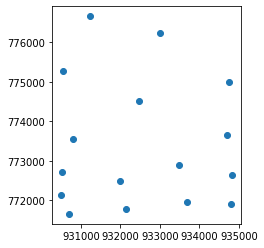

In [12]:
taz_maz.query("TAZ_REG == 466").plot();

But the joined GeoDataFrame only has the centroids.  To get the 
MAZ shapes, we need to put those shapes into the joined result.

In [14]:
taz_maz.geometry = maz.geometry

Then we can plot the MAZ's, adding a little context by using some 
map tiles to render a basemap as well.

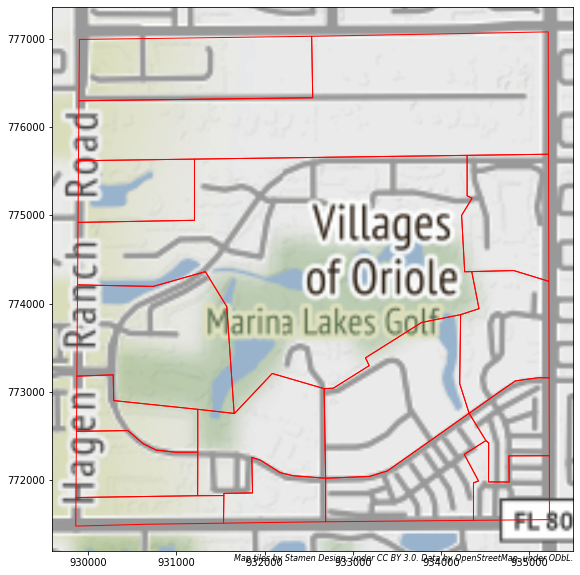

In [15]:
ax = taz_maz.query("TAZ_REG == 466").plot(color='none',edgecolor='red')
tt.mapping.add_basemap(ax, zoom=14, crs=maz.crs);

This TAZ is not bisected by any major roads, but the poor internal
interconnectivity (the northernmost quarter of the TAZ is not accessible
from the rest of the TAZ without going on on Hagen Ranch Road, and the
presence of the golf course in the middle of the TAZ) makes the large
number of MAZ's important to model this area well.